In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tests.leandro.mini_connectome import *
from tests.leandro.plots import *
from omegaconf import OmegaConf
from data._main import *
from statsmodels.tsa.stattools import grangercausalitytests

In [3]:
import warnings
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_analysis(x, y, maxlag=10, verbose=False):
    """
    Perform Granger causality analysis between two time series vectors.

    Args:
        x (array-like): First time series vector.
        y (array-like): Second time series vector.
        maxlag (int): Maximum lag order to consider (default: 10).
        verbose (bool): Whether to print the results (default: False).

    Returns:
        dict: Dictionary containing the Granger causality test results.

    """
    # Convert the input arrays to numpy arrays if needed
    x = np.asarray(x)
    y = np.asarray(y)

    # Reshape the input arrays to be 2-dimensional
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Combine the input arrays into a single 2-dimensional array
    data = np.concatenate((x, y), axis=1)

    # Suppress the warning
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        # Perform the Granger causality test
        results = grangercausalitytests(data, maxlag=maxlag, verbose=verbose)

    return results

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(time, series, lags=30):
    """
    Plot the Autocorrelation Function (ACF), Partial Autocorrelation Function (PACF),
    and the time series in a grid layout.

    Args:
        series (array-like): Time series data.
        lags (int): Number of lags to consider (default: 30).

    Returns:
        None

    """

    # Convert series to numpy array, just in case
    series = np.asarray(series)

    fig = plt.figure(figsize=(16,6))

    # Plot ACF
    ax1 = fig.add_subplot(2, 2, 1)
    plot_acf(series, ax=ax1, lags=lags)
    ax1.set_title('ACF')
    ax1.set_xlabel('Lag (in time steps)')
    ax1.set_ylabel('Autocorrelation')

    # Plot PACF
    ax2 = fig.add_subplot(2, 2, 2)
    plot_pacf(series, ax=ax2, lags=lags)
    ax2.set_title('PACF')
    ax2.set_xlabel('Lag (in time steps)')
    ax2.set_ylabel('Partial Autocorrelation')

    # Plot the time series itself
    ax3 = fig.add_subplot(2, 1, 2)
    ax3.plot(time, series)
    ax3.set_title('Neural activity')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Calcium signal')

    plt.tight_layout()
    plt.show()


In [4]:
miniconnectome = MiniConnectome(direction='TD', group_by='four')
connected_to_M3L = miniconnectome.get_connected_neurons('M3L', index=False)
miniconnectome.minigraph.add_nodes('M3L', connected_to_M3L)
miniconnectome.minigraph.add_nodes(connected_to_M3L[0], miniconnectome.get_connected_neurons(connected_to_M3L[0], index=False))
miniconnectome.minigraph.add_nodes(connected_to_M3L[1], miniconnectome.get_connected_neurons(connected_to_M3L[1], index=False))

for neuron_name in ['I4', 'I6', 'M3R', 'I2L', 'I2R']:
    connected_neurons = miniconnectome.get_connected_neurons(neuron_name, index=False)
    if 'NSML' in connected_neurons:
        miniconnectome.minigraph.add_nodes(neuron_name, ['NSML'])
    if 'NSMR' in connected_neurons:
        miniconnectome.minigraph.add_nodes(neuron_name, ['NSMR'])

miniconnectome.minigraph.display(save=False, filename='M3L.png')
#miniconnectome.minigraph.print()

My goal here is to study the interdependence between the M3L and NSML signals.

In [5]:
config = OmegaConf.load("/home/lrvnc/Projects/worm-graph/conf/dataset.yaml")
dataset = get_dataset(config)

Chosen dataset(s): ['Flavell2023']
Num. worms: 50



In [57]:
signals = []

for wormID, data in dataset.items():
    neuron_names = [value for key, value in data['slot_to_named_neuron'].items()]
    if ('M3L' in neuron_names) and ('NSML' in neuron_names) and ('NSMR' in neuron_names):
        X = data['smooth_calcium_data'] # (time, all neurons)

        X = X[:, [data['named_neuron_to_slot']['M3L'], data['named_neuron_to_slot']['NSML'], data['named_neuron_to_slot']['NSMR']]]
        signals.append([data['time_in_seconds'], X])

        #plot_signals(data['smooth_calcium_data'], data['time_in_seconds'], [data['named_neuron_to_slot']['M3L'], data['named_neuron_to_slot']['NSML'], data['named_neuron_to_slot']['NSMR']], yax_limit=False)

# ACF and PACF
---

Decide the max lag window

/home/lrvnc/miniconda3/envs/worm-graph/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


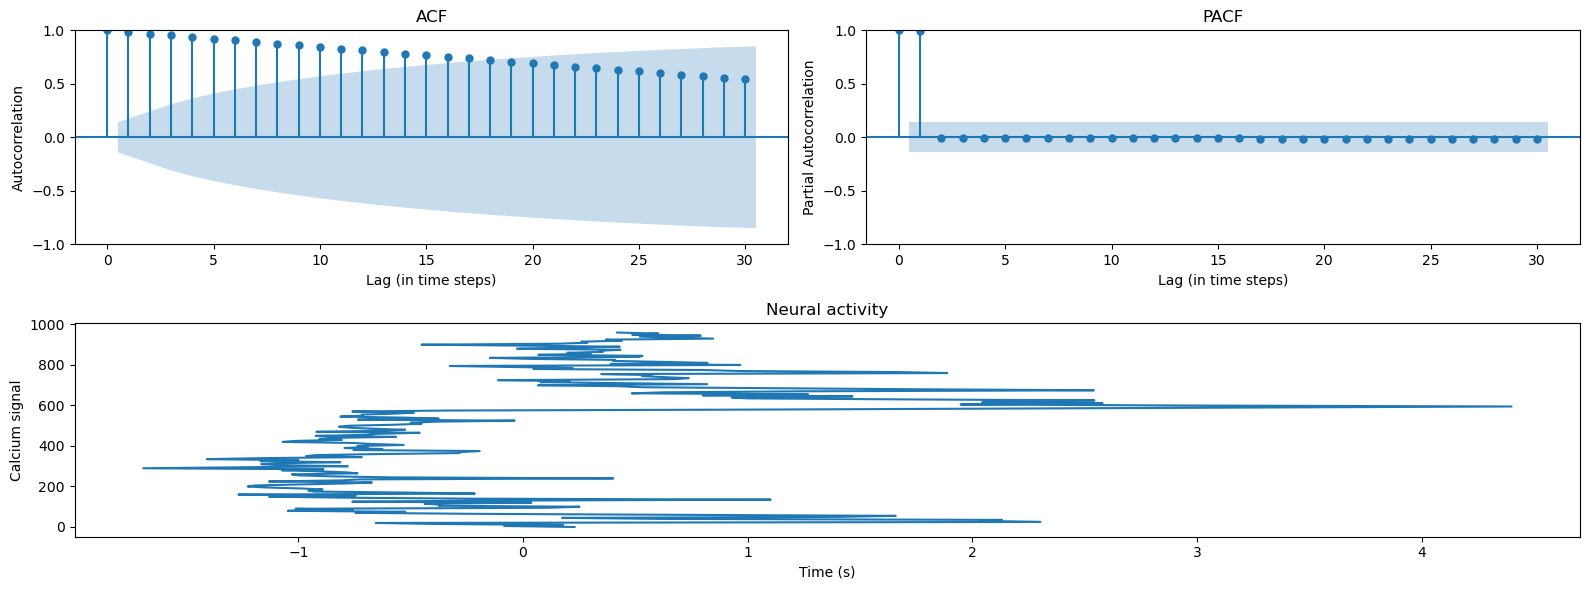

In [60]:
plot_acf_pacf(signals[0][0][::50, 0], signals[0][1][::50, 0])

In [9]:
_ = granger_causality_analysis(signal[:, 0], signal[:, 1], maxlag=10, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3511  , p=0.5535  , df_denom=9616, df_num=1
ssr based chi2 test:   chi2=0.3512  , p=0.5534  , df=1
likelihood ratio test: chi2=0.3512  , p=0.5534  , df=1
parameter F test:         F=0.3511  , p=0.5535  , df_denom=9616, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=237.7642, p=0.0000  , df_denom=9613, df_num=2
ssr based chi2 test:   chi2=475.7758, p=0.0000  , df=2
likelihood ratio test: chi2=464.3823, p=0.0000  , df=2
parameter F test:         F=237.7642, p=0.0000  , df_denom=9613, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=20.7157 , p=0.0000  , df_denom=9610, df_num=3
ssr based chi2 test:   chi2=62.1924 , p=0.0000  , df=3
likelihood ratio test: chi2=61.9922 , p=0.0000  , df=3
parameter F test:         F=20.7157 , p=0.0000  , df_denom=9610, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=82.2002 , p=0.